## 1. 将数据集划分成训练集、验证集、测试集并存储成TFRecord文件

In [3]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data


# 将训练集和测试集分为训练集、验证集和测试集
data = input_data.read_data_sets('data_initial',           # 读取的时候规定好dtype
                                    dtype=tf.uint8,
                                    reshape=False,
                                ) 


#  转为tfrecord文件
# 路径
config = [{'dir': 'data_initial/train/', 'type': 'train'},
          {'dir': 'data_initial/validation/', 'type': 'validation'},
          {'dir': 'data_initial/test/', 'type': 'test'},
          ]

for each in range(len(config)):
    mnist_dir = config[each]['dir']
    mnist_type = config[each]['type']
    # tfrecord格式文件名
    with tf.python_io.TFRecordWriter('mnist_' + mnist_type + '.tfrecords') as writer:
        image_path = data[each].images
        for num_images in range(image_path.shape[0]):
            image_byte = data[each].images[num_images].tobytes()
            label = data[each].labels[num_images]
            example = tf.train.Example(features=tf.train.Features(feature={  
                    "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[int(label)])),  
                    'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_byte]))  
                }))
            writer.write(example.SerializeToString())
print('successful')

Extracting data_initial/train-images-idx3-ubyte.gz
Extracting data_initial/train-labels-idx1-ubyte.gz
Extracting data_initial/t10k-images-idx3-ubyte.gz
Extracting data_initial/t10k-labels-idx1-ubyte.gz
successful


## 2.利用matplotlib等工具对TFRecord中的样本数据进行可视化，以验证存储在TFRecord文件中的样本与标记的完整性与对应性，并对数据集有个直观的认识。



### 2.1 读取tfrecord中代码，并转化为矩阵的函数（有正确率提高5%左右的改进）

In [3]:
import tensorflow as tf
from PIL import Image
import numpy as np


def read_tfrecord(config_dir, num = 1):   
    # 读取tfrecord代码      
    filename_queue = tf.train.string_input_producer([config_dir])    # 创建输入队列，读入流中
    reader = tf.TFRecordReader()
    _, example = reader.read(filename_queue)  # 返回文件名和文件

    # 取出包含有image 和 label的feature对象
    features = tf.parse_single_example(example,
                                        features={'label': tf.FixedLenFeature([], tf.int64),
                                                    'data': tf.FixedLenFeature([], tf.string)})  # 将对应的内存块读为张量流
    image = tf.decode_raw(features['data'], tf.uint8)  # tf.decode_raw可以将字符串解析成图像对应的像素组
    image = tf.cast(image, tf.float32)    # 解码之后转数据类型 
    image = tf.reshape(image, [28, 28])
    label = tf.cast(features['label'], tf.int32)  # 类型转换
    # 随机读取数据，验证图片对应正确性
    image_batch, label_batch = tf.train.shuffle_batch([image, label],
                                                        batch_size=1,
                                                        capacity=100,
                                                        min_after_dequeue=50)

    # 开始一个会话
    with tf.Session() as sess:
        exm_images = np.zeros((num, 784))
        exm_labels = np.zeros((num, 1))

        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init)
        # 启动多线程
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)
        for count in range(num):

            image, label = sess.run([image_batch, label_batch])  # 在会话中取出image和label
            img = image.reshape([28, 28])  # 这里要reshape因为默认一个批次处理的数据会外层嵌套一层
            img = img.astype(np.uint8)  # PIL保存时，必须是整数
            if num == 1:
                coord.request_stop()  
                coord.join(threads)
                return img, label       # 在进行图片验证时使用
            else:
                image = image.reshape(784)
                # for i in range(784):
                #     # if image[i] > 127:
                #     #     image[i] = 1
                #     # else:
                #     #     image[i] = 0     # 改进 ： 会让正确率提高5% 左右
                image = image / 255
                exm_images[count, :] = image
                exm_labels[count, :] = label
                if count % 10000 == 0:
                    print(count)
        coord.request_stop()  
        coord.join(threads)
    return exm_images, exm_labels        # 在进行算法读取数据矩阵时使用
     

### 2.2 将读取到的数据可视化

[3] 

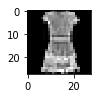

[1] 

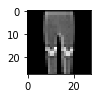

[7] 

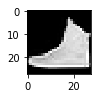

[2] 

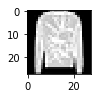

[5] 

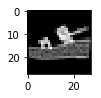

[0] 

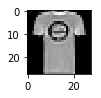

[1] 

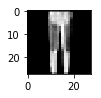

[2] 

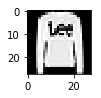

[1] 

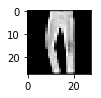

In [5]:
# 读取tfrecord代码 , 并验证
for each in range(len(config)):
    config_path = 'mnist_' + config[each]['type'] + '.tfrecords'
    for num in range(3):
        [img, label] = read_tfrecord(config_path)
        sub = int('33' + str(3*each + 1 + num))
        print(label, end=' ')
        plt.subplot(sub)
        plt.imshow(img, cmap='gray')
        plt.show()         

## 3.设计并训练KNN算法对图片进行分类

In [6]:
from numpy import *
import operator
import os

# 分类函数

def kNNClassify(newInput, dataSet, labels, k):
    numSamples = dataSet.shape[0]  # shape[0] stands for the num of row
  
    # step 1:计算欧式距离
    diff = tile(newInput, (numSamples, 1)) - dataSet # 单个测试样本与训练样本中的每一个数据做比较
    squaredDiff = diff ** 2 
    squaredDist = sum(squaredDiff, axis = 1) 
    distance = squaredDist ** 0.5
  
    # step 2: 对距离进行分类
    sortedDistIndices = argsort(distance)     # 将x中的元素从小到大排列，提取其对应的index(索引)，然后输出到y
  
    classCount = {} 
    for i in range(k):
        # step 3: 找最小距离
        voteLabel = labels[sortedDistIndices[i]][0]
  
        # step 4: 分类与次数一一对应
        classCount[voteLabel] = classCount.get(voteLabel, 0) + 1
    # step 5: 返回投票结果
    maxCount = 0
    for key, value in classCount.items():
        if value > maxCount:
            maxCount = value
            maxIndex = key
    return maxIndex


# 分类正确率
def testHandWritingClass():
    print("step 1: load data...")
    [train_x, train_y] = read_tfrecord('mnist_train.tfrecords', 55000)
    [test_x, test_y] = read_tfrecord('mnist_test.tfrecords', 500)
    
     
    print("step 2: testing...")
    numTestSamples = test_x.shape[0]
    matchCount = 0
    for i in range(numTestSamples):
        predict = kNNClassify(test_x[i], train_x, train_y, 5)
        if predict == test_y[i]:
            matchCount += 1
        if i % 100 == 0:
            print(i)
    accuracy = float(matchCount) / numTestSamples

    print("step 3: show the result...") 
    print('The classify accuracy is: %.2f%%' % (accuracy * 100))

testHandWritingClass()


step 1: load data...
0
10000
20000
30000
40000
50000
0
step 2: testing...
0
100
200
300
400
step 3: show the result...
The classify accuracy is: 88.00%


## 4. 设计并训练K-Means算法对图片进行聚类。

0
迭代次数 0
迭代次数 1
迭代次数 2
迭代次数 3
迭代次数 4
迭代次数 5
迭代次数 6
迭代次数 7
迭代次数 8
迭代次数 9
迭代次数 10
迭代次数 11
迭代次数 12
迭代次数 13
迭代次数 14
迭代次数 15
迭代次数 16
迭代次数 17
迭代次数 18
迭代次数 19
[array([ 7.05993557, -2.70343399]), array([-0.68891263, -0.00077361]), array([ 2.83054304,  3.81508303]), array([ 6.07010555,  2.00236368]), array([-0.07463504,  5.06325531]), array([-3.56224871, -4.16163635]), array([-3.24616647,  3.12645507]), array([ 0.87645352, -5.54367018]), array([-6.24179792, -0.42718276]), array([ 3.20638084, -1.27282405])]


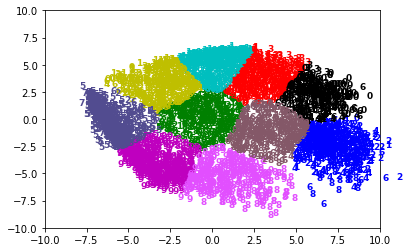

In [3]:
import numpy as np
from numpy import array
import tensorflow as tf
import matplotlib.pyplot as plt
from random import choice, shuffle



# 实现主成分分析

def pca(data_mat, top_n_feat=99999999):
    # 获取数据条数和每条的维数
    num_data, dim = data_mat.shape

    # 数据中心化，即指变量减去它的均值
    mean_vals = data_mat.mean(axis=0)  # shape:(784,)
    mean_removed = data_mat - mean_vals  # shape:(5000, 784)

    cov_mat = np.cov(mean_removed, rowvar=0)    # 计算协方差矩阵

    # 计算特征值(Find eigenvalues and eigenvectors)
    eig_vals, eig_vects = np.linalg.eig(np.mat(cov_mat))  # 计算特征值和特征向量

    eig_val_index = np.argsort(eig_vals)  # 对特征值进行从小到大排序，argsort返回的是索引，即下标

    eig_val_index = eig_val_index[:-(top_n_feat + 1): -1]  # 最大的前top_n_feat个特征的索引
    reg_eig_vects = eig_vects[:, eig_val_index] 

    # 将数据转到新空间
    low_d_data_mat = mean_removed * reg_eig_vects
    recon_mat = (low_d_data_mat * reg_eig_vects.T) + mean_vals  # 根据前几个特征向量重构回去的矩阵，shape:(5000, 784)

    return low_d_data_mat, recon_mat


# 实现k-means 算法

def KMeansCluster(vector, noofclusters):
    noofclusters = int(noofclusters)
    assert noofclusters < len(vector)

    # 找出每个向量的维度
    num_data, dim = vector.shape
    # 将复数矩阵转换为浮点数矩阵
    vectors = np.zeros((num_data, 2))
    for count in range(num_data):
        temp = [vector.real[count, 0], vector.real[count, 1]]
        vectors[count, :] = temp

    # 辅助随机地从可得的向量中选取中心点
    vector_indices = list(range(len(vectors)))
    shuffle(vector_indices)

    # 计算图
    # 创建一个默认的计算流的图用于整个算法中，这样就保证了当函数被多次调用时，默认的图并不会被从上一次调用时留下的未使用的OPS或者Variables挤满
    graph = tf.Graph()
    with graph.as_default():
        # 计算的会话
        sess = tf.Session()
        # 构建基本的计算的元素
        # 首先需要保证每个中心点都会存在一个Variable矩阵
        # 从现有的点集合中抽取出一部分作为默认的中心点
        centroids = [tf.Variable((vectors[vector_indices[i]]))
                     for i in range(noofclusters)]
        # 创建一个placeholder用于存放各个中心点可能的分类的情况
        centroid_value = tf.placeholder("float64", [dim])
        cent_assigns = []
        for centroid in centroids:
            cent_assigns.append(tf.assign(centroid, centroid_value))
        # 对于每个独立向量的分属的类别设置为默认值0
        assignments = [tf.Variable(0) for i in range(len(vectors))]
        # 这些节点在后续的操作中会被分配到合适的值
        assignment_value = tf.placeholder("int32")
        cluster_assigns = []
        for assignment in assignments:
            cluster_assigns.append(tf.assign(assignment,
                                             assignment_value))
        # 下面创建用于计算平均值的操作节点
        # 输入的placeholder
        mean_input = tf.placeholder("float", [None, dim])
        # 节点/OP接受输入，并且计算0维度的平均值，譬如输入的向量列表
        mean_op = tf.reduce_mean(mean_input, 0)
        # 用于计算欧几里得距离的节点
        v1 = tf.placeholder("float", [dim])
        v2 = tf.placeholder("float", [dim])
        euclid_dist = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(
            v1, v2), 2)))
        # 这个OP会决定应该将向量归属到哪个节点
        # 基于向量到中心点的欧几里得距离
        # Placeholder for input
        centroid_distances = tf.placeholder("float", [noofclusters])
        cluster_assignment = tf.argmin(centroid_distances, 0)
        # 初始化所有的状态值
        # 这会帮助初始化图中定义的所有Variables。Variable-initializer应该定义在所有的Variables被构造之后，这样所有的Variables才会被纳入初始化
        init_op = tf.global_variables_initializer()
        # 初始化所有的变量
        sess.run(init_op)
        # 集群遍历
        # 接下来在K-Means聚类迭代中使用最大期望算法。为了简单起见，只让它执行固定的次数，而不设置一个终止条件
        noofiterations = 20
        for iteration_n in range(noofiterations):
            print('迭代次数', iteration_n)

            # 期望步骤
            # 基于上次迭代后算出的中心点的未知
            # the _expected_ centroid assignments.
            # 首先遍历所有的向量
            for vector_n in range(len(vectors)):
                vect = vectors[vector_n]
                # 计算给定向量与分配的中心节点之间的欧几里得距离
                distances = [sess.run(euclid_dist, feed_dict={
                    v1: vect, v2: sess.run(centroid)})
                             for centroid in centroids]   
                # 下面可以使用集群分配操作，将上述的距离当做输入
                assignment = sess.run(cluster_assignment, feed_dict = {
                    centroid_distances: distances})
                # 接下来为每个向量分配合适的值
                sess.run(cluster_assigns[vector_n], feed_dict={
                    assignment_value: assignment})
            # 最大化的步骤
            # 基于上述的期望步骤，计算每个新的中心点的距离从而使集群内的平方和最小
            for cluster_n in range(noofclusters):
                # 收集所有分配给该集群的向量
                assigned_vects = [vectors[i] for i in range(len(vectors))
                                  if sess.run(assignments[i]) == cluster_n]
                # 计算新的集群中心点
                new_location = sess.run(mean_op, feed_dict={
                    mean_input: array(assigned_vects)})
                # 为每个向量分配合适的中心点
                sess.run(cent_assigns[cluster_n], feed_dict={
                    centroid_value: new_location})
        # 返回中心节点和分组
        centroids = sess.run(centroids)
        assignments = sess.run(assignments)
        return centroids, assignments


# 获取数据
[data_mat, data_label] = read_tfrecord('mnist_train.tfrecords', 5000)

# 只取最重要的两个特征
low_2_mat, recon_784_mat = pca(data_mat, 2)

# 获取中心点 
k = 10
center, result = KMeansCluster(low_2_mat, k)
print(center)

# 画出聚类结果，每一类用一种颜色
colors = ['b', 'g', 'r', 'k', 'c', 'm', 'y', '#e24fff', '#524C90', '#845868']
n_clusters = 10
for i in range(n_clusters):
    indexs = [index for index in range(5000) if result[index] == i]
    x0 = low_2_mat[indexs, 0]
    x1 = low_2_mat[indexs, 1]
    y_i = data_label[indexs]
    for j in range(len(x0)):
        plt.text(x0[j], x1[j], str(int(y_i[j])), color=colors[i], 
                fontdict={'weight': 'bold', 'size': 9})
    plt.scatter(center[i][0], center[i][1], marker='x', color=colors[i], linewidths=12)
plt.axis([-10, 10, -10, 10])
plt.show()


## 5.设计并训练NN算法对图片进行分类。

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

# 设置按需使用GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)   # 启动计算图

# 导入数据
train_x, train_y = read_tfrecord('mnist_train.tfrecords', 55000)
test_x, test_y = read_tfrecord('mnist_test.tfrecords', 10000)

# 将  _y（labels）转换为one-hot 类型
# 1.转换函数
def dense_to_one_hot(labels_dense, num_classes=10):
    labels_dense = labels_dense.astype(np.uint8)   # 转换数据类型
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot
# 2.函数实现
train_y = dense_to_one_hot(train_y, 10)
test_y = dense_to_one_hot(test_y, 10)
print(train_y.shape)
print(test_y.shape)


# min_next_batch_tfr(随机批次载入数据)
def min_next_batch_tfr(image, label, num=50): 
    images = np.zeros((num, 784))
    labels = np.zeros((num, 10))
    for i in range(num):
        temp = random.randint(0, 54999)
        images[i, :] = image[temp]
        labels[i, :] = label[temp]

    return images, labels


# 参数保存目录
FLAGS = tf.app.flags.FLAGS
# Basic model parameters.
tf.app.flags.DEFINE_string('cnn_path', './cnn_model', """存放模型的目录""")

tf.app.flags.DEFINE_string('cnn_parameters', 'mnist',"""模型的名称""")


# 构建网络, 写为函数，可以在网络中方便调用

# 权值初始化，随机选取，返回的值中不会偏离均值的两倍差
def weight_variable(shape):
    # 用正态分布来初始化权值
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# 偏值的初始化
def bias_variable(shape):
    # 本例中用relu激活函数，所以用一个很小的正偏置较好
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# 定义卷积层
def conv2d(x, W):
    # 默认 strides[0]=strides[3]=1, strides[1]为x方向步长，strides[2]为y方向步长
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')    # 返回feature map

# 定义池化层
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#模型文件所在的文件夹，是否存在，如果不存在，则创建文件夹
ckpt = tf.train.latest_checkpoint(FLAGS.cnn_path)
if not ckpt:
    if not os.path.exists(FLAGS.cnn_path):
        os.mkdir(FLAGS.cnn_path)

# X_ 是手写图像的像素值， y是图像对应的标签
X_ = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# 把X转为卷积所需要的形式
# 输入层为输入的灰度图像尺寸
X = tf.reshape(X_, [-1, 28, 28, 1])
# 第一层卷积：5×5×1卷积核32个 [5，5，1，32],h_conv1.shape=[-1, 28, 28, 32]
W_conv1 = weight_variable([5, 5, 1, 32])  # 卷积核的大小、深度和数量
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(X, W_conv1) + b_conv1)

# 第一个池化层[-1, 28, 28, 32]->[-1, 14, 14, 32]
h_pool1 = max_pool_2x2(h_conv1)

# 第二层卷积：5×5×32卷积核64个 [5，5，32，64],h_conv2.shape=[-1, 14, 14, 64]
W_conv2 = weight_variable([5, 5, 32, 64])  # 卷积核的大小、深度和数量
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

# 第二个池化层,[-1, 14, 14, 64]->[-1, 7, 7, 64] 
h_pool2 = max_pool_2x2(h_conv2)

# flatten层，[-1, 7, 7, 64]->[-1, 7*7*64],即每个样本得到一个7*7*64维的样本
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

# 全连接层，隐藏层节点为1024个
# 权值初始化
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# 全连接隐藏层/输出层
# 为了防止网络出现过拟合的情况,对全连接隐藏层进行 Dropout(正则化)处理,在训练过程中随机的丢弃部分
# 节点的数据来防止过拟合.Dropout同把节点数据设置为0来丢弃一些特征值,仅在训练过程中,
# 预测的时候,仍使用全数据特征
# 传入丢弃节点数据的比例
# dropout: 输出的维度和h_fc1一样，只是随机部分值被值为零
keep_prob = tf.placeholder(tf.float32)   # 正则化，丢弃比例
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# 输出层与全连接隐藏层之间
# 隐藏层与输出层权重初始化
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

# 激活后的输出
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)


# 训练和评估

# 1.损失函数：cross_entropy  交叉熵代价函数
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
# 2.优化函数：AdamOptimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# 3.预测准确结果统计
# 预测值中最大值（１）即分类结果，是否等于原始标签中的（１）的位置。argmax()取最大值所在的下标
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
# 准确率
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# 保存
saver = tf.train.Saver(max_to_keep=2)

# 全局初始化
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(FLAGS.cnn_path, sess.graph)

ckpt = tf.train.latest_checkpoint(FLAGS.cnn_path)
step = 0
if ckpt:
    saver.restore(sess=sess, save_path=ckpt)
    step = int(ckpt[len(os.path.join(FLAGS.cnn_path, FLAGS.cnn_parameters)) + 1:])

# 开启线程
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)
# 训练
# for i in range(20000):   ## 20000
#     batch = min_next_batch_tfr(train_x, train_y, 50)
#     if i % 1000 == 0:   ## 1000
#         train_accuracy = accuracy.eval(feed_dict={
#              X_: batch[0], y_: batch[1], keep_prob: 1.0})
#         print("step %d, training accuracy %g" % (i, train_accuracy))
#                 ckptname=os.path.join(FLAGS.cnn_path, FLAGS.cnn_parameters)
#         saver.save(sess,ckptname,global_step=i)
# train_step.run(feed_dict={X_: batch[0], y_: batch[1], keep_prob: 0.5})
    
for j in range(200):
    testSample_start = j * 50      
    testSample_end = (j + 1) * 50  
    print('test %d accuracy %g' % (j, accuracy.eval(session=sess, feed_dict={
        X_: test_x[testSample_start:testSample_end],
        y_: test_y[testSample_start:testSample_end], keep_prob: 1.0})))  # f喂数据
coord.request_stop() 
coord.join(threads)


0
